# riverbed parameters

Thanks to this script we will carry out an inversion of the parameters of the riverbed, t
The inversion will focus on the four uncertain parameters and one boundary condition of this model, namely:

- the porosity $n$
- the intinsic permeability k,
- the thermal condictivity, 
- the heat capacity, 



# 1. Initiation Ginnette files

In [327]:
#!/usr/bin/env python

import os
import numpy as np
from pathlib import Path
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display
import subprocess
import glob
import itertools
import seaborn as sns
import array
from scipy.interpolate import CubicSpline

libs_gfortran = ['gfortran']
# Définissez le répertoire où se trouvent les fichiers CSV
Obs_data = '../OBS_point/station1/'

#-----------------------------------------------------------------
########### Setup of the model

#time step in s
dt=900
#duration of the simulation in days
nb_day=30
date_simul_bg=pd.to_datetime("2019-05-03 10:30:00")
# state
## 0 steady state
# 1 transient state (dynamic state)
state=1
coef=1
ost=0
# size columnin meter
z_top=0.0
z_bottom=-0.4
#Observation positions x 0.50000
#Observation in meter
Obs1=z_top-0.1
Obs2=z_top-0.2
Obs3=z_top-0.3
Obs4=z_top-0.4

az=abs(z_top-z_bottom)
#discretisation : size cell in meter
dz=0.01

# number of facies in the column. If nb_zone=1 homognous porous media
nb_zone=2
#cote de la limitein meter, if you want more layer just add a new line
alt_thk=-0.25

# number of cell
nb_cell=az/dz

# porosity
REF_n=0.2 # \omega
#-----------------------------------------------------------------
# constant parameters
## intrinsic permeability [m2]  k=K*mu/(rho*g)
## K hydraulic conductivity [m.s-1]
## mu viscosity [Pa.s]
## rho density [kg.m-3]
## g gravity  9.81 [m2.s-1]
REF_k=3.33333333333333e-10
# solid grain density rho_s=val_r  [kg.m-3]
REF_r=1600


# Heat capacity is calculated  by the following relationship
#  c_pm= c_w r_w n  * sat+ c_s r (1-n) + c_a r_a n * (1-sat)
# 1.5 e+6 4e+6
#rho_m imposed : 1000
# high slow
# density
# c_s solid specific heat capacity
#val_c= c_s m2/s2/C I advice to let this value constant.
# There are no way to calibrate the both parameter rho and c in the same time.
#c_w=4185D+00	       m2/s2/C
#r_w=1000  kg/m3
# solid density r=val_r 
REF_c=1900
REF_l=8 #

if nb_zone==2:
    # zone 1
    # porosity
    REF_n=0.10 # \omega
    # intrinsic permeability [m2]  k=K*mu/(rho*g)
    REF_k=6e-30
    # Heat capacity
    REF_r=2500
    #lambda
    REF_l=7
    # zone 2
    # porosity
    REF_n2=0.05 # \omega
    # intrinsic permeability [m2]  k=K*mu/(rho*g)
    REF_k2=6e-15
    # solid grain density rho_s=val_r  [kg.m-3]
    REF_r2=1600
    REF_l2=3



# please compile ginette in the folder 1D_col
# path of the 1D_col directory
os.chdir('/home/ariviere/Programmes/ginette/application/sauer/GINETTE_SENSI/')
# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

#-----------------------------------------------------------------
# Compile ginette
if os.path.isfile('ginette'):
    print ("ginette exist")
else:
    print ("ginette not exist")
    print("you must compile ginette in the current directory")
    print(" gfortran -o ginette ../../src/ginette_V2.f")
    subprocess.call(["gfortran","-o","ginette","../../../src/ginette_V2.f"])  #creat


print("la simulation commence à",date_simul_bg)
#-----------------------------------------------------------------
## write the setup of the moddeled domain
f_param_bck=open("E_parametre_backup.dat", "r")
f_param_new = open("E_parametre.dat", 'w')
setup_model=f_param_bck.read()
setup_model=setup_model.replace('[dt]','%06.0fD+00' % dt)
setup_model=setup_model.replace('[state]','%1i' % state)
setup_model=setup_model.replace('[nb_day]','%06.0f' % nb_day)
setup_model=setup_model.replace('[z_top]', '%7.3e' % z_top)
setup_model=setup_model.replace('[z_bottom]', '%7.2e' % z_bottom)
setup_model=setup_model.replace('[az]','%7.3e' % az)
setup_model=setup_model.replace('[dz]','%6.2e' % dz)
setup_model=setup_model.replace('[nb_cell]','%05.0f' % nb_cell)

cell1=abs(Obs1/dz)
cell2=abs(Obs2/dz)
cell3=abs(Obs3/dz)
cell4=abs(Obs4/dz)

setup_model=setup_model.replace('[cell1]','%05d' % cell1)
setup_model=setup_model.replace('[cell2]','%05d' % cell2)
setup_model=setup_model.replace('[cell3]','%05d' % cell3)
setup_model=setup_model.replace('[cell4]','%05d' % cell4)



f_param_new.write(setup_model)
f_param_bck.close()
f_param_new.close()






Current working directory: /home/ariviere/Programmes/ginette/application/sauer/GINETTE_SENSI
ginette exist
la simulation commence à 2019-05-03 10:30:00


# 2. Read observation data

In [328]:

# Obtenez la liste des fichiers dans le répertoire
fichiers = os.listdir(Obs_data)

info = None
all_data = None

for fichier in fichiers:
    if fichier.endswith('.csv'):
        if 'info' in fichier:
            info = pd.read_csv(os.path.join(Obs_data, fichier))
        elif 'pressure' in fichier:
            all_p = pd.read_csv(os.path.join(Obs_data, fichier))
            all_p.rename(columns={all_p.columns[1]: 'tension'}, inplace=True)
            all_p.rename(columns={all_p.columns[2]: 'TempMolo'}, inplace=True)
            all_p.rename(columns={all_p.columns[3]: 'deltaP'}, inplace=True)
        elif 'temperature' in fichier:
            all_t = pd.read_csv(os.path.join(Obs_data, fichier))
# rename columns 0 by date all_p all_t
all_p.rename(columns={all_p.columns[0]: 'dates'}, inplace=True)


all_p.rename(columns={all_p.columns[1]: 'tension'}, inplace=True)
all_p.rename(columns={all_p.columns[2]: 'TempMolo'}, inplace=True)
all_p.rename(columns={all_p.columns[3]: 'deltaP'}, inplace=True)
all_t.rename(columns={all_t.columns[0]: 'dates'}, inplace=True)
all_t.rename(columns={all_t.columns[1]: 'Temp1'}, inplace=True)
all_t.rename(columns={all_t.columns[2]: 'Temp2'}, inplace=True)
all_t.rename(columns={all_t.columns[3]: 'Temp3'}, inplace=True)
all_t.rename(columns={all_t.columns[4]: 'Temp4'}, inplace=True)
#print name of columns
print('all_t',all_t.columns)
print('all_p',all_p.columns)
# merge all_p and all_t            
# merge all_p and all_t            
all_data = pd.merge(all_p, all_t, on='dates', how='outer')
print('all_data',all_data.columns)
print(all_data['dates'].iloc[0])


all_t Index(['dates', 'Temp1', 'Temp2', 'Temp3', 'Temp4', 'Stream_temperature_S1'], dtype='object')
all_p Index(['dates', 'tension', 'TempMolo', 'deltaP'], dtype='object')
all_data Index(['dates', 'tension', 'TempMolo', 'deltaP', 'Temp1', 'Temp2', 'Temp3',
       'Temp4', 'Stream_temperature_S1'],
      dtype='object')
2019-05-03 10:30:00


In [329]:
all_data['dates']=pd.to_datetime(all_data['dates'],format='%Y-%m-%d %H:%M:%S')
all_data=all_data[all_data['dates']>date_simul_bg]
# Réindexer le DataFrame
all_data.reset_index(drop=True, inplace=True)
all_data['deltaP']=all_data['deltaP']*coef+ost

date_begin= all_data['dates'].iloc[0]
date_end = pd.to_datetime(date_begin) + pd.to_timedelta(nb_day, unit='d')
print(date_begin,date_end)
# pas de temps
time_diff = all_data['dates'].diff().dropna()
indices_not_equal_900_sec = time_diff[time_diff != pd.Timedelta(seconds=900)].index

# pas de temps=900s
is_equal_900_sec = all(time_diff == pd.Timedelta(seconds=900))

if len(indices_not_equal_900_sec) == 0:
    print("Toutes les différences entre les lignes sont de 900 secondes.")
else:
    print("Les différences ne sont pas toutes de 900 secondes. Voici les indices concernés :")
    print(indices_not_equal_900_sec)
    # Afficher les lignes correspondantes dans le dataframe
    print(all_data.loc[indices_not_equal_900_sec])
all_data['dates']


2019-05-03 10:45:00 2019-06-02 10:45:00
Toutes les différences entre les lignes sont de 900 secondes.


0       2019-05-03 10:45:00
1       2019-05-03 11:00:00
2       2019-05-03 11:15:00
3       2019-05-03 11:30:00
4       2019-05-03 11:45:00
                ...        
21401   2019-12-12 09:00:00
21402   2019-12-12 09:15:00
21403   2019-12-12 09:30:00
21404   2019-12-12 09:45:00
21405   2019-12-12 10:00:00
Name: dates, Length: 21406, dtype: datetime64[ns]

In [330]:
# Trouver les horodatages qui ne commencent pas à des intervalles de 15 minutes et ajuster uniquement ceux-là
#mask = all_data['dates'].dt.minute % 15 != 0
#all_data.loc[mask, 'timestamps'] = all_data.loc[mask, 'dates'] - pd.to_timedelta(all_data.loc[mask, 'dates'].dt.minute % 15, unit='m')
# Réinitialiser les secondes à zéro pour tous les horodatages
all_data['dates'] = all_data['dates'].dt.floor('min')
all_data['dates'] = all_data['dates'].dt.floor('15T')


In [331]:

all_data['timestamps']=all_data['dates']

# Créez un nouvel index avec des dates toutes les 15 minutes
new_index = pd.date_range(start=all_data['timestamps'].min(), end=all_data['timestamps'].max(), freq='15T')

# Réindexez le DataFrame pour inclure ces nouvelles dates
all_data = all_data.set_index('timestamps').reindex(new_index)
# Sélection des colonnes pour l'interpolation
columns_to_interpolate = ['deltaP', 'TempMolo', 'Temp1', 'Temp2', 'Temp3', 'Temp4']

# Appliquez l'interpolation uniquement sur la colonne 'valeur'
all_data[columns_to_interpolate] = all_data[columns_to_interpolate].interpolate(method='time')




In [332]:

# Vérification des écarts temporels après l'interpolation
time_diff = all_data['dates'].diff().dropna()
indices_not_equal_900_sec = time_diff[time_diff != pd.Timedelta(seconds=900)].index

if len(indices_not_equal_900_sec) == 0:
    print("Toutes les différences entre les lignes sont de 900 secondes.")
else:
    print("Les différences ne sont pas toutes de 900 secondes. Voici les indices concernés :")
    print(indices_not_equal_900_sec)
    # Afficher les lignes correspondantes dans le dataframe
    print(all_data.loc[indices_not_equal_900_sec])

Toutes les différences entre les lignes sont de 900 secondes.


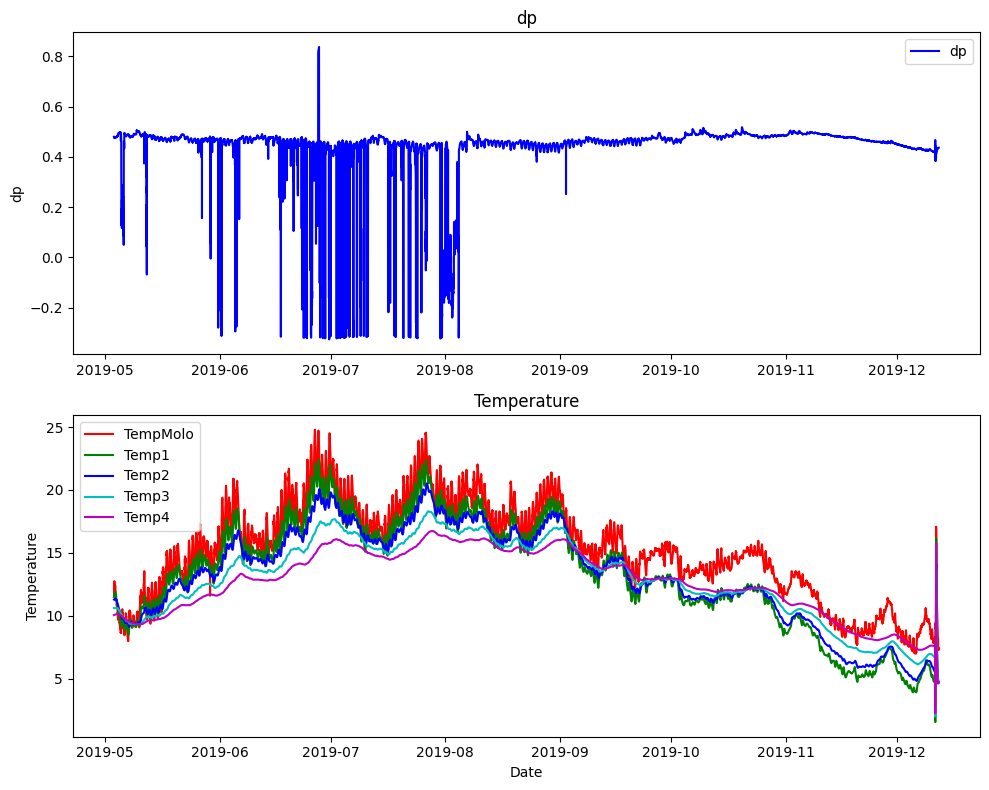

In [333]:
all_data= all_data[ (all_data['dates'] < '2022-12-01')]
# Creating subplots for 'dp' and 'temp' graphs vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plotting 'dp'
ax1.plot(all_data['dates'], all_data['deltaP'], 'b-', label='dp')
ax1.set_ylabel('dp')
ax1.set_title('dp')
ax1.legend()

# Plotting 'Temps'
temp_columns = ['TempMolo', 'Temp1', 'Temp2', 'Temp3', 'Temp4']
colors = ['r', 'g', 'b', 'c', 'm']
for i, col in enumerate(temp_columns):
    ax2.plot(all_data['dates'], all_data[col], color=colors[i], label=col)

ax2.set_xlabel('Date')
ax2.set_ylabel('Temperature')
ax2.set_title('Temperature')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

# Zoom temperature



In [359]:
filtered_data = all_data[(all_data['dates'] > '2019-05-03 10:30:00') & (all_data['dates'] < '2019-06-03 10:30:00')]


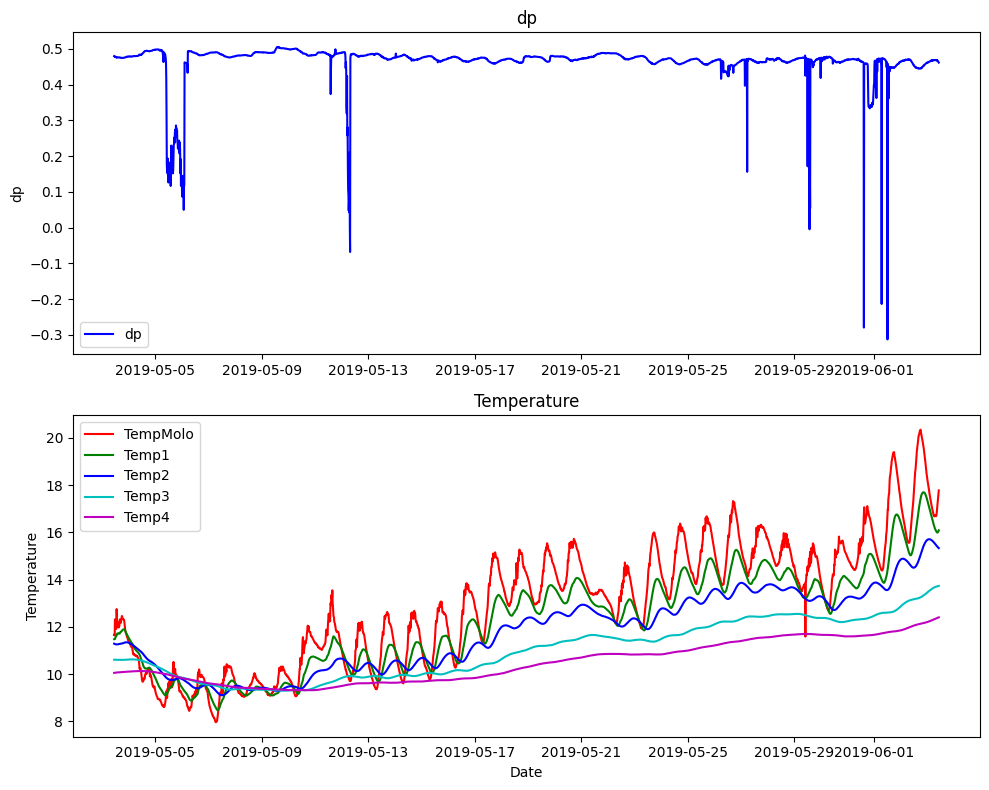

In [360]:
# Creating subplots for 'dp' and 'temp' graphs vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plotting 'dp'
ax1.plot(filtered_data['dates'],filtered_data['deltaP'], 'b-', label='dp')
ax1.set_ylabel('dp')
ax1.set_title('dp')
ax1.legend()

# Plotting 'Temps'
temp_columns = ['TempMolo', 'Temp1', 'Temp2', 'Temp3', 'Temp4']
colors = ['r', 'g', 'b', 'c', 'm']
for i, col in enumerate(temp_columns):
    ax2.plot(filtered_data['dates'], filtered_data[col], color=colors[i], label=col)

ax2.set_xlabel('Date')
ax2.set_ylabel('Temperature')
ax2.set_title('Temperature')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

## 2. Reference simulation 

In [361]:
########### Zone of parameters
f_coor=open("E_coordonnee.dat", "w")
f_zone=open("E_zone.dat", 'w')
f_paramZ_bck=open("E_zone_parameter_backup.dat", "r")
f_paramZ_new = open("E_zone_parameter.dat", 'w')

param_zone=f_paramZ_bck.read()
coord=pd.DataFrame()    

# replace the parameter values
param_zone=param_zone.replace('[k1]','%8.2e' % REF_k)
param_zone=param_zone.replace('[n1]','%6.2f' % REF_n)
param_zone=param_zone.replace('[l1]','%6.2f' % REF_l)
param_zone=param_zone.replace('[r1]','%6.2f' % REF_r)

if nb_zone ==2 :
    f_param_bck.close()
    f_paramZ_bck=open("E_zone_parameter_backup_2zones.dat","r")
    param_zone=f_paramZ_bck.read()
    param_zone=param_zone.replace('[k1]','%8.2e' % REF_k)
    param_zone=param_zone.replace('[n1]','%6.2f' % REF_n)
    param_zone=param_zone.replace('[l1]','%6.2f' % REF_l)
    param_zone=param_zone.replace('[r1]','%6.2f' % REF_r)
    param_zone=param_zone.replace('[k2]','%8.2e' % REF_k2)
    param_zone=param_zone.replace('[n2]','%6.2f' % REF_n2)
    param_zone=param_zone.replace('[l2]','%6.2f' % REF_l2)
    param_zone=param_zone.replace('[r2]','%6.2f' % REF_r2)
                      
    
# Coodrinate  
zvalues =  np.sort(np.arange(z_bottom+dz/2,dz/2,dz ))

xvalues = np.array([0.5])
zz, xx = np.meshgrid(zvalues, xvalues)
NT = np.product(zz.shape)
data = {
    "x": np.reshape(xx,NT),
    "z": np.reshape(zz,NT)}
coord = pd.DataFrame(data=data)
coord['id']=coord.index.values.astype(int)
coord['id']=coord['id']+1
cols = coord.columns.tolist()
cols = cols[-1:] + cols[:-1]
coord = coord[cols] 
coord.to_csv(f_coor, index = False, sep=' ', header=False)
#zone parameter by cell ((homogenous domain = 1 zone))
coord['zone'] =1


#Pour plusieurs zones modification AR
if nb_zone >= 2:
        coord['zone'] = np.where(coord['z'] >= alt_thk, 2,coord['zone'])
#Write new ginette files
f_paramZ_new.write(param_zone)

coord.zone.to_csv(f_zone, index = False, header=False)

# close files    
f_zone.close()
f_coor.close()
f_paramZ_new.close()
f_paramZ_bck.close()






# Inital conditions
f_temp_IC=open("E_temperature_initiale.dat","w")
initial_temps = all_data.iloc[0][['Temp1', 'Temp2', 'Temp3', 'Temp4']]
z_temps = np.array([-0.1, -0.2, -0.3, -0.4])
initial = pd.DataFrame({'z': z_temps, 'T': initial_temps})
initial['z'] = initial['z'].astype(float)
initial['T'] = initial['T'].astype(float)


# Define the range of depths for interpolation
dz_bot=z_bottom+dz/2
dz_top=z_top+0.001
z_values = np.arange(dz_bot, 0.001, dz)  # Depth range from -0.4 to 0.005

# Perform linear interpolation
Temp_init = np.interp(z_values, initial['z'][::-1], initial['T'][::-1])  # Reversed to align with depths

# Creating a DataFrame for the interpolated data
interpolated_temp = {
    'z': z_values,
    'T': Temp_init
}

interpolated_temp = pd.DataFrame(interpolated_temp)
interpolated_temp_sorted = interpolated_temp.sort_values(by='z', ascending=False)

interpolated_temp_sorted['T'].to_csv(f_temp_IC, index = False, sep='\n', header=False)

# To apply dp to the column, we need to convert it to a pressure value
f_chg_IC=open("E_charge_initiale.dat","w")
initial_pres = all_data.iloc[0][['deltaP']]
initial_chg = pd.DataFrame({'z': z_bottom, 'chg': [0]})
new_row = pd.DataFrame({'z': z_top, 'chg':initial_pres})
initial_chg = pd.concat([initial_chg, new_row], ignore_index=True)
initial_chg['z'] = initial_chg['z'].astype(float)
initial_chg['chg'] = initial_chg['chg'].astype(float)
# Define the range of depths for interpolation
dz_bot=z_bottom+dz/2
dz_top=z_top+0.001
z_values = np.arange(dz_bot, 0.001, dz)  # Depth range from -0.4 to 0.005


# Perform linear interpolation
charge_init = np.interp(z_values, initial_chg['z'][:], initial_chg['chg'][:])  # Reversed to align with depths

# Creating a DataFrame for the interpolated data
interpolated_chg = {
    'z': z_values,
    'chg': charge_init
}
interpolated_chg = pd.DataFrame(interpolated_chg)
interpolated_chg_sorted = interpolated_chg.sort_values(by='z', ascending=False)



interpolated_chg_sorted['chg'].to_csv(f_chg_IC, index = False, sep='\n', header=False)

f_chg_IC.close()
f_temp_IC.close()

In [362]:
# Boundary conditions
all_data['bot']=0
all_data['top']=all_data['deltaP']*-1
all_data[['top','bot']].to_csv('E_charge_t.dat', sep=' ', index=False, header=False)
all_data[['Temp1', 'Temp4']].to_csv('E_temp_t.dat', sep=' ', index=False, header=False)

In [363]:
# run ginette
subprocess.call(["./ginette"])

0

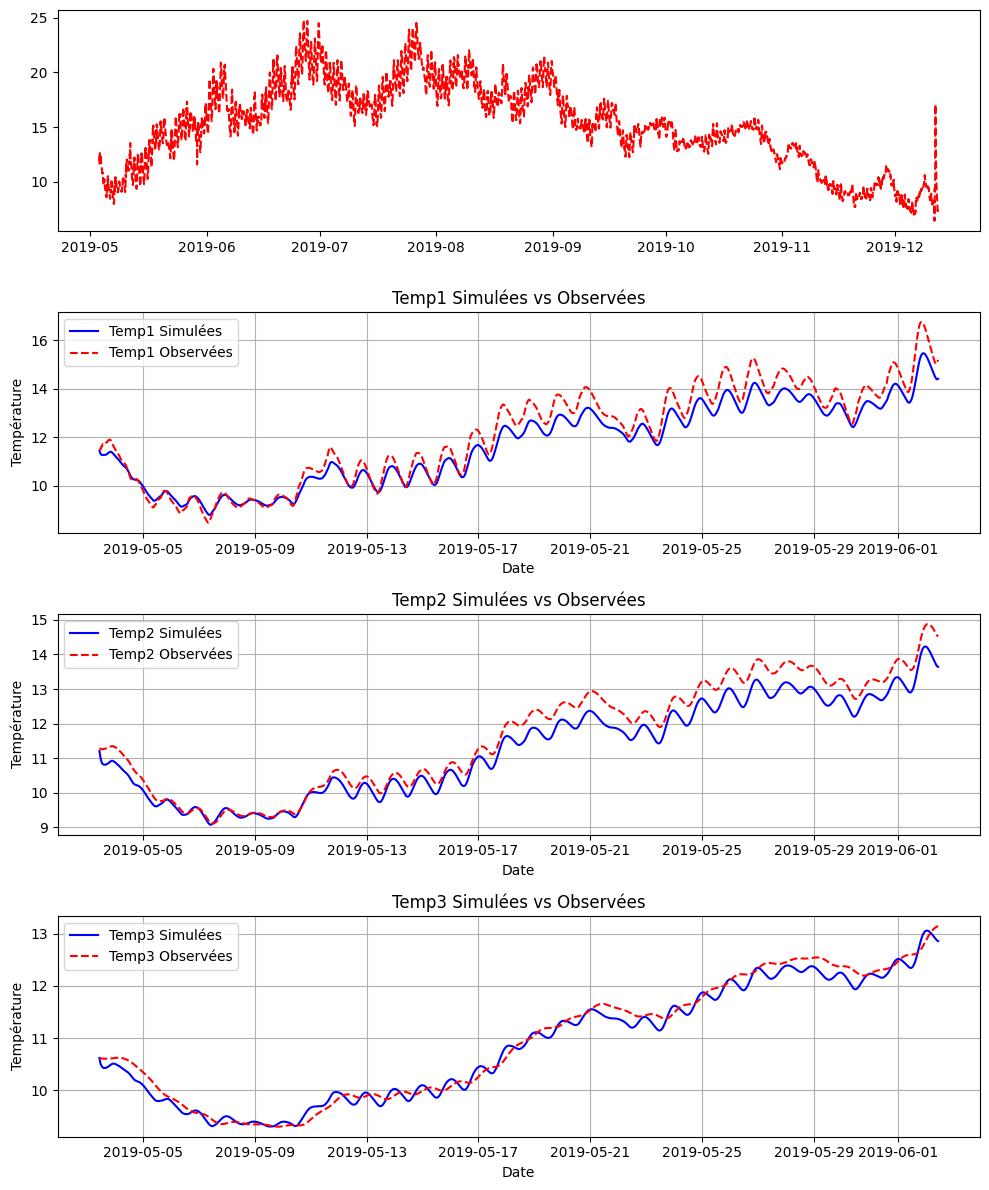

In [364]:
# Colonnes pour les températures
column_names = ['Temp_1', 'Temp_2', 'Temp_3']

# Liste pour stocker les DataFrames
all_dfs = []
# Lire et stocker les DataFrames
for i in range(1,4 ):
    file_path = f'Sim_temperature_maille{i}_t.dat'
    df = pd.read_csv(file_path, sep='\s+', header=None, names=['Time', f'Temp{i}'])
    all_dfs.append(df)

# Fusionner les DataFrames sur la colonne 'Time'
sim_temp = all_dfs[0]  # Utiliser le premier DataFrame comme base

for df in all_dfs[1:]:
    sim_temp = pd.merge(sim_temp, df, on='Time', how='outer')

# Trier les colonnes par ordre numérique
sim_temp = sim_temp.reindex(sorted(sim_temp.columns), axis=1)
sim_temp['dates'] = pd.to_datetime(date_simul_bg) + pd.to_timedelta(sim_temp['Time'], unit='s')

obs_temp = all_data[all_data['dates'] < date_end]
# Tracer les températures simulées et observées pour chaque température
fig, axs = plt.subplots(4, 1, figsize=(10, 12))
axs[0].plot(all_data['dates'], all_data['TempMolo'], label='TempMolo Observées', linestyle='--', color='red')
# Tracer les températures simulées (sim_temp)
for i in range(1, 4):
    axs[i].plot(sim_temp['dates'], sim_temp[f'Temp{i}'], label=f'Temp{i} Simulées', linestyle='-', color='blue')

# Tracer les températures observées (sim_obs)
  
for i in range(1, 4):
    axs[i].plot(obs_temp['dates'], obs_temp[f'Temp{i}'], label=f'Temp{i} Observées', linestyle='--', color='red')

    # Configurations supplémentaires pour chaque subplot
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Température')
    axs[i].set_title(f'Temp{i} Simulées vs Observées')
    axs[i].legend()
    axs[i].grid(True)

# Afficher les subplots
plt.tight_layout()
plt.show()


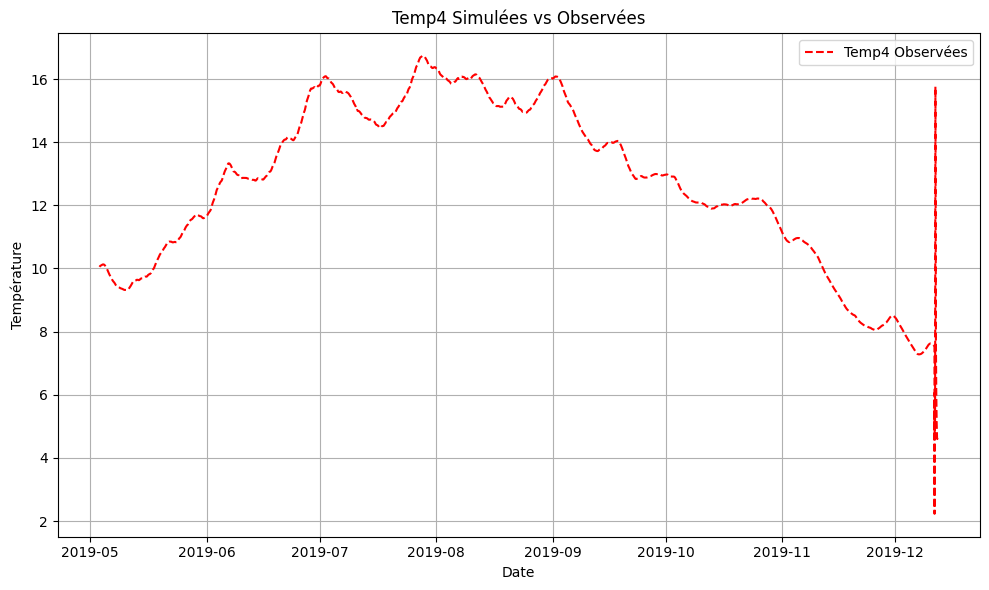

In [367]:
# Colonnes pour les températures
column_names = ['Temp_4']


# plot Temp4 
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(all_data['dates'], all_data['Temp4'], label='Temp4 Observées', linestyle='--', color='red')

ax.set_xlabel('Date')
ax.set_ylabel('Température')
ax.set_title('Temp4 Simulées vs Observées')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


In [345]:
# Fusionner les DataFrames en fonction des dates communes
merged_data = pd.merge(obs_temp, sim_temp, on='dates', how='inner')
merged_data = merged_data.rename(columns={
    'Temp1_x': 'Temp1_obs',
    'Temp2_x': 'Temp2_obs',
    'Temp3_x': 'Temp3_obs',
    'Temp1_y': 'Temp1_sim',
    'Temp2_y': 'Temp2_sim',
    'Temp3_y': 'Temp3_sim'
})

merged_data

,dates,tension,TempMolo,deltaP,Temp1_obs,Temp2_obs,Temp3_obs,Temp4,Stream_temperature_S1,bot,top,Temp1_sim,Temp2_sim,Temp3_sim,Time
0,2019-05-03 10:45:00,1.18437,11.662,0.479834,11.479,11.289,10.609,10.053,11.662,0,-0.479834,11.431609,11.207189,10.619010,900.0
1,2019-05-03 11:00:00,1.18498,11.662,0.479471,11.487,11.283,10.609,10.055,11.662,0,-0.479471,11.397184,11.144394,10.579685,1800.0
2,2019-05-03 11:15:00,1.18498,11.637,0.479520,11.487,11.277,10.608,10.056,11.637,0,-0.479520,11.365607,11.088795,10.547651,2700.0
3,2019-05-03 11:30:00,1.18620,12.316,0.477466,11.485,11.272,10.608,10.058,12.316,0,-0.477466,11.335560,11.038236,10.524018,3600.0
4,2019-05-03 11:45:00,1.18559,12.316,0.477829,11.514,11.268,10.608,10.059,12.316,0,-0.477829,11.311095,10.993224,10.505887,4500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,2019-06-02 09:30:00,1.19292,16.415,0.465454,15.054,14.560,13.139,12.012,16.415,0,-0.465454,14.391190,13.668075,12.877753,2588400.0
2876,2019-06-02 09:45:00,1.19475,16.558,0.464086,15.079,14.548,13.144,12.016,16.558,0,-0.464086,14.389184,13.658507,12.872858,2589300.0
2877,2019-06-02 10:00:00,1.19597,16.677,0.463127,15.112,14.536,13.147,12.021,16.677,0,-0.463127,14.391832,13.651010,12.868667,2590200.0
2878,2019-06-02 10:15:00,1.19780,16.796,0.461806,15.149,14.527,13.151,12.025,16.796,0,-0.461806,14.398789,13.645721,12.865242,2591100.0


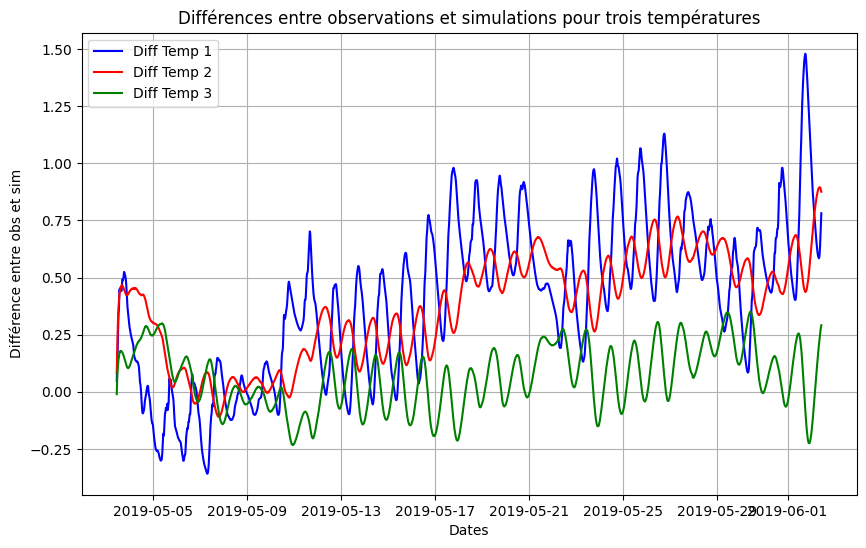

In [346]:
# Calculer les différences entre les températures simulées et observées
merged_data['Diff_Temp1'] = merged_data['Temp1_obs'] - merged_data['Temp1_sim']
merged_data['Diff_Temp2'] = merged_data['Temp2_obs'] - merged_data['Temp2_sim']
merged_data['Diff_Temp3'] = merged_data['Temp3_obs'] - merged_data['Temp3_sim']



# Création du graphique
plt.figure(figsize=(10, 6))

plt.plot(merged_data['dates'], merged_data['Diff_Temp1'], label='Diff Temp 1', color='blue')
plt.plot(merged_data['dates'], merged_data['Diff_Temp2'], label='Diff Temp 2', color='red')
plt.plot(merged_data['dates'], merged_data['Diff_Temp3'], label='Diff Temp 3', color='green')

plt.xlabel('Dates')
plt.ylabel('Différence entre obs et sim')
plt.title('Différences entre observations et simulations pour trois températures')
plt.legend()
plt.grid(True)

plt.show()

In [347]:
import numpy as np

def calculate_metrics(data):
    metrics = {}

    for i in range(1, 4):
        sensor = f'Temp{i}'
        diff_sensor = f'Diff_Temp{i}'

        diff = data[diff_sensor]
        
        rmse = np.sqrt(np.mean(diff**2))  # RMSE
        mae = np.mean(np.abs(diff))  # MAE
        bias = 100 * np.sum(diff) / np.sum(np.abs(data[f'{sensor}_obs']))  # PBias

        std_obs = data[f'{sensor}_obs'].std()
        std_sim = data[f'{sensor}_sim'].std()
        mean_obs = data[f'{sensor}_obs'].mean()
        mean_sim = data[f'{sensor}_sim'].mean()

        kge = 1 - np.sqrt((np.square(std_sim/std_obs - 1)) +
                            (np.square(mean_sim/mean_obs - 1)) +
                            (np.square(rmse/std_obs - 1)))

        metrics[sensor] = {'RMSE': rmse, 'MAE': mae, 'PBias': bias, 'KGE': kge}

    return metrics

# Appel de la fonction pour calculer les métriques pour chaque capteur
metrics_dict = calculate_metrics(merged_data)

# Affichage des résultats
for sensor, metrics in metrics_dict.items():
    print(f"Métriques pour {sensor}:")
    print(f"RMSE: {metrics['RMSE']}")
    print(f"MAE: {metrics['MAE']}")
    print(f"PBias: {metrics['PBias']}")
    print(f"KGE: {metrics['KGE']}")
    print()


Métriques pour Temp1:
RMSE: 0.5338953118418406
MAE: 0.4428240161559243
PBias: 3.3410450519661765
KGE: 0.25616970582215315

Métriques pour Temp2:
RMSE: 0.43604080089330016
MAE: 0.37580671058958964
PBias: 3.193883839176439
KGE: 0.2663707855629972

Métriques pour Temp3:
RMSE: 0.15137363699582268
MAE: 0.12517575883886836
PBias: 0.6299739885841211
KGE: 0.13122869157029093



# Flux eau

In [348]:
flux_eau=pd.read_csv('Sim_velocity_profil_t.dat',sep='\s+',header=None)
flux_eau = flux_eau.rename(columns={0: 'Time', 1: 'z', 2: 'v'})
flux_eau

,Time,z,v
0,900.0,-0.005,0.0
1,900.0,-0.015,0.0
2,900.0,-0.025,0.0
3,900.0,-0.035,0.0
4,900.0,-0.045,0.0
...,...,...,...
115195,2592000.0,-0.355,0.0
115196,2592000.0,-0.365,0.0
115197,2592000.0,-0.375,0.0
115198,2592000.0,-0.385,0.0


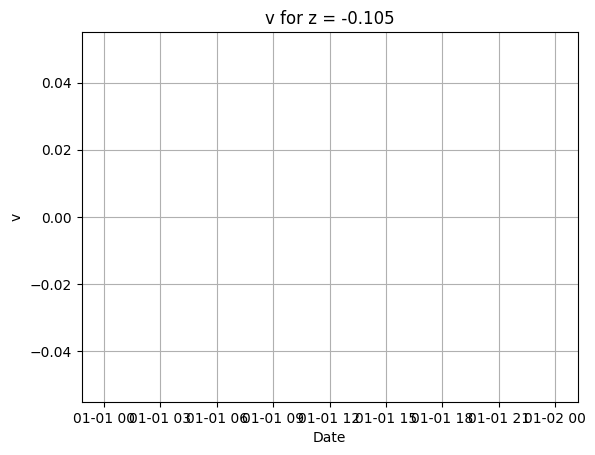

In [349]:
flux_eau['dates'] = pd.to_datetime(date_simul_bg) + pd.to_timedelta(flux_eau['Time'], unit='s')

selected_data = flux_eau[flux_eau['z'] == -0.105]
plt.plot(selected_data['dates'], selected_data['v'])
plt.xlabel('Date')
plt.ylabel('v')
plt.title('v for z = -0.105')
plt.grid(True)
plt.show()
